# Are They Masked?

- Student: Luís Guilherme Gaboardi Lins
- Registration: 180022962
- Date: 04/2023
- Lesson 1

## Installing Requirements

In [2]:
# Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [6]:
# This can throw an error, but it doesn't affect the solution
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

# General Explanation

In the following the steps used to model a solution that identifies, in a given image of a person, whether he or she is wearing a mask or not, will be described.

This project is relevant, in a pandemic context, to be used in a place that has as an entrance requirement the wearing of a facemask. This control can be done, for example, through a photograph when entering the establishment.

## Steps

1. Use DuckDuckGo to search for images of a single person wearing or not facemask with the search strings: "person photos" and "person wearing facemask photos";
1. Fine-tune a pretrained neural network to recognise these two groups;
1. Test this model on two new pictures, one with a person wearing a facemask and the other don't, and see if it works.

## Step 1: Download images of people wearing and not wearing facemaks

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

# Declaring the texts that are going to be used to find images from DuckDuckGo
search_string = 'one person','one person wearing facemask'

# The function uses the ddg_images function from the duckduckgo_search package to search for images related to the term.
#  It passes the term and max_results parameters to the ddg_images function to retrieve the image URLs.
#  The function returns the list of image URLs and also prints a message indicating the search term that was used.
def search_images(term, max_images=80):
    print(f"Searching for '{term}'\n\n")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

### Saving the images that are going to be used for testing

Firstly, the picture with a person NOT wearing a facemask

Searching for 'one person photos'




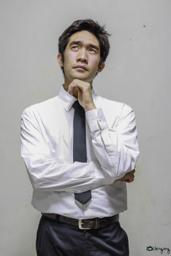

In [5]:
from fastdownload import download_url

urls = search_images(search_string[0] + ' photos', max_images=1)

# person
dest = search_string[0] + '.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
Image.open(dest).to_thumb(256,256)

Now the picture with a person wearing a facemask

Searching for 'one person wearing facemask photos'




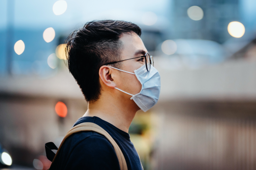

In [7]:
urls = search_images(search_string[1] + ' photos', max_images=1)

# person wearing facemask
dest = search_string[1] + '.jpg'
download_url(urls[0], dest, show_progress=False)
Image.open(dest).to_thumb(256,256)

Next, we create the folder, that work as labels to divide the 2 categories of photos, and download the images of unmasked and masked people

In [8]:
path = Path('unmasked_or_masked')

for label in search_string:
    dest = (path/label)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{label} photo', 100))
    resize_images(path/label, max_size=400, dest=path/label)

print('OK!\n')

Searching for 'one person photo'


Searching for 'one person wearing facemask photo'


OK!



Some photos might not download correctly which could cause our model training to fail, so they will be removed

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

## Step 2: Train our model

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

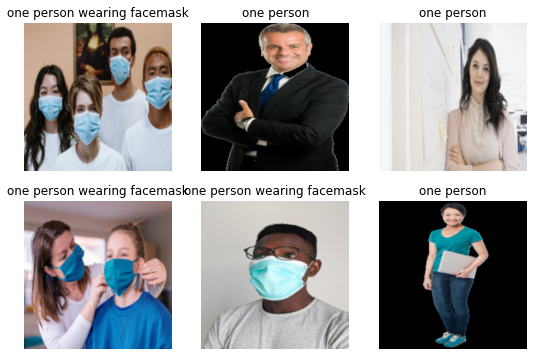

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=37),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.210786,1.069251,0.277778,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.464677,0.454276,0.138889,00:01
1,0.266290,0.195729,0.055556,00:01
2,0.199070,0.178679,0.055556,00:01


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories).

## Step 3: Test the model

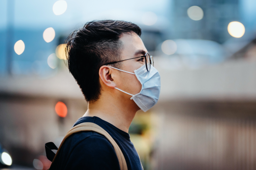

In [12]:
# You can change the index to 0 or 1, being "person" and "person wearing facemask", respectfully
image = search_string[1] + '.jpg'
Image.open(image).to_thumb(256,256)

In [13]:
is_masked,_,probs = learn.predict(PILImage.create(image))
print(f"This is {is_masked}.")
print(f"Probability he/she is masked: {1 - probs[0]:.4f}")

This is one person wearing facemask.
Probability he/she is masked: 0.9999
